In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/FoodSeg103"

/content/drive/MyDrive/Colab Notebooks/FoodSeg103


In [3]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers==4.44.2 albumentations==1.4.8 opencv-python tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 117.5 MB/s eta 0:00:00


In [ ]:
!pip install -U albumentations==1.4.7 albucore==0.0.8

  Using cached albumentations-1.4.7-py3-none-any.whl.metadata (37 kB)
Using cached albumentations-1.4.7-py3-none-any.whl (155 kB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C


In [5]:
import torch
import torch.nn as nn
import os
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

In [6]:
BATCH_SIZE = 6
EPOCHS = 10

In [7]:
# ----------------------------
# Dataset 정의
# ----------------------------
class FoodSeg103(Dataset):
    IMG_EXTS  = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
    MASK_EXTS = {'.png', '.bmp', '.tif', '.tiff'}

    def __init__(self, img_dir, mask_dir, img_transform=None, size=(256, 256)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.size = size

        imgs = [f for f in os.listdir(img_dir)
                if not f.startswith('.') and os.path.splitext(f)[1].lower() in self.IMG_EXTS]
        masks = [f for f in os.listdir(mask_dir)
                 if not f.startswith('.') and os.path.splitext(f)[1].lower() in self.MASK_EXTS]

        def to_map(files):
            d = {}
            for f in files:
                stem, ext = os.path.splitext(f)
                d.setdefault(stem, []).append(f)
            return d

        img_map  = to_map(imgs)
        mask_map = to_map(masks)

        common_stems = sorted(set(img_map.keys()) & set(mask_map.keys()))
        if not common_stems:
            raise RuntimeError("No matching image/mask pairs found.")

        self.data = []
        for stem in common_stems:
            img_file  = sorted(img_map[stem])[0]
            mask_file = sorted(mask_map[stem])[0]
            self.data.append((os.path.join(img_dir, img_file),
                              os.path.join(mask_dir, mask_file)))

        self._to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def _read_image_rgb(self, path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Failed to read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def _read_mask_gray(self, path):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask: {path}")
        return mask

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        img  = self._read_image_rgb(img_path)
        mask = self._read_mask_gray(mask_path)

        if self.size is not None:
            w, h = self.size
            img  = cv2.resize(img,  (w, h), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        if self.img_transform is not None:
            img_pil = Image.fromarray(img)
            img = self.img_transform(img_pil)
        else:
            img = self._to_tensor(img)

        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return img, mask

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

IMG_SIZE = 512

# ----- Train aug (적당히 강함) -----
train_aug = A.Compose([
    # 1) 크롭+리사이즈 (비율 살짝 변형)
    A.RandomResizedCrop(
        height=IMG_SIZE, width=IMG_SIZE,
        scale=(0.5, 1.0), ratio=(0.75, 1.33),
        interpolation=cv2.INTER_LINEAR, p=1.0
    ),

    # 2) 기하 변환 (패딩은 0, 마스크는 255로)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.06, scale_limit=0.10, rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=255, p=0.6
    ),

    # 3) 색상/블러 (초기 수렴 방해 줄이려 확률 낮춤)
    A.ColorJitter(brightness=0.10, contrast=0.20, saturation=0.20, hue=0.03, p=0.35),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),

    # 4) CoarseDropout(occlusion) — 너무 세지 않게
    A.CoarseDropout(
        max_holes=4,
        min_height=IMG_SIZE//32, min_width=IMG_SIZE//32,
        max_height=IMG_SIZE//12, max_width=IMG_SIZE//12,
        fill_value=0, mask_fill_value=255, p=0.2
    ),

    # 5) 정규화 + 텐서
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# ----- Val/Test aug (증강 없음) -----
val_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.9, 1.1], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.9, 1.1], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  Pydan

In [10]:
class FoodSeg103Alb(FoodSeg103):
    def __init__(self, img_dir, mask_dir, aug):
        # size=None → Albumentations에서 Resize/RandomCrop 처리
        super().__init__(img_dir, mask_dir, img_transform=None, size=None)
        self.aug = aug

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        img  = self._read_image_rgb(img_path)
        mask = self._read_mask_gray(mask_path)

        # Albumentations는 dict 반환
        out = self.aug(image=img, mask=mask)
        img  = out["image"]                        # (3,H,W) tensor(float)
        mask = torch.as_tensor(out["mask"], dtype=torch.long)  # (H,W) long tensor
        return img, mask

train_dataset = FoodSeg103Alb('data/img_dir/train','data/ann_dir/train', aug=train_aug)
val_dataset   = FoodSeg103Alb('data/img_dir/train','data/ann_dir/train', aug=val_aug)   # 같은 폴더라도 aug는 다름
test_dataset  = FoodSeg103Alb('data/img_dir/test', 'data/ann_dir/test',  aug=val_aug)

In [11]:

train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=0,pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0,pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0,pin_memory=True,)

In [12]:
# ----------------------------
# IoU 계산 함수
# ----------------------------
def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

In [13]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# ----------------------------
# SegFormer 모델 정의
# ----------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")   # 코랩 GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")    # 맥북 M1/M2 GPU
else:
    device = torch.device("cpu")    # CPU fallback

print("Using device:", device)

NUM_CLASSES = 104
config = SegformerConfig.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")
config.num_labels = NUM_CLASSES
config.id2label = {i: str(i) for i in range(NUM_CLASSES)}
config.label2id = {str(i): i for i in range(NUM_CLASSES)}
config.label_ignore_index = 255
config.semantic_loss_ignore_index = 255
config.reduce_labels = False

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    config=config,
    ignore_mismatched_sizes=True
).to(device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([104, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([104]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

# 채널라스트
model = model.to(memory_format=torch.channels_last)
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
      m.to(memory_format=torch.channels_last)
# Fused AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=0.01, fused=True)

In [15]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5)

In [16]:
def visualize_img(img, mask):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    img_plot = img.permute(1, 2, 0)
    axes[0].imshow(img_plot)
    axes[0].set_title("Image")
    axes[1].imshow(mask)
    axes[1].set_title("Mask")

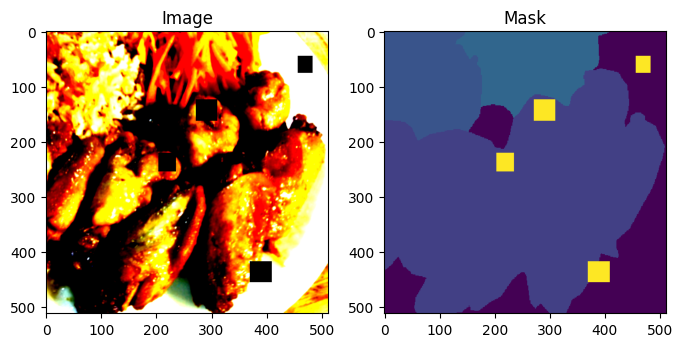

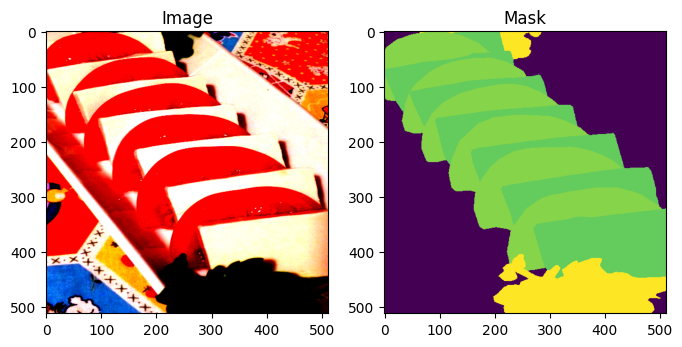

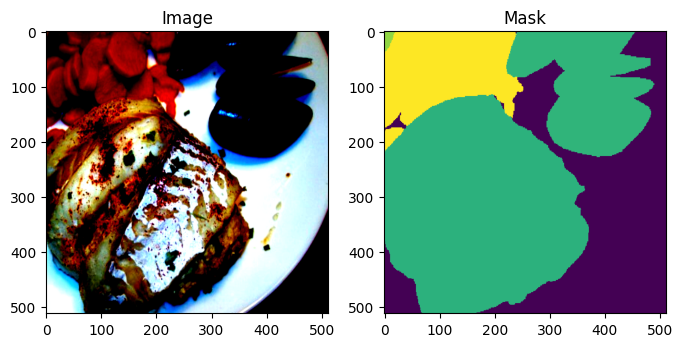

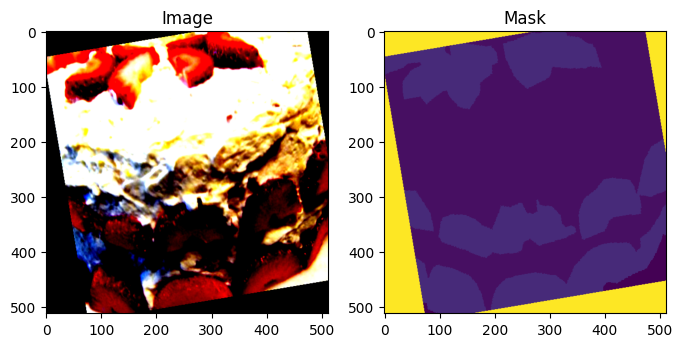

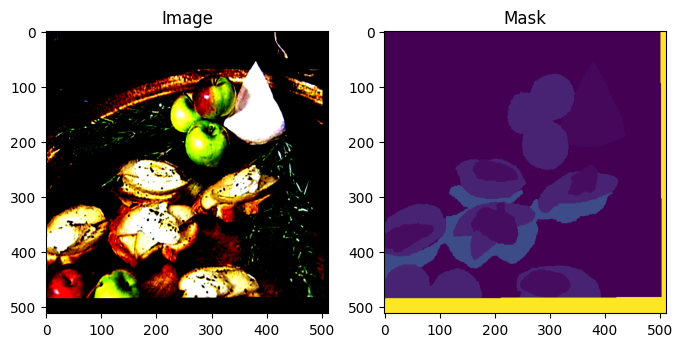

In [17]:
for i in range(100,105):
    img, mask = train_dataset[i]
    visualize_img(img, mask)

In [18]:
img, mask = train_dataset[0]
uniques = np.unique(mask.numpy())
print("mask unique:", uniques[:50], " ... ", len(uniques))

mask unique: [  0  39  58  89 255]  ...  5


In [19]:
def dice_loss(logits, target, ignore_index=255, eps=1e-6):
    """
    logits: (B, C, H, W), raw scores
    target: (B, H, W),    long class ids
    """
    logits = logits.float()
    target = target.long()
    B, C, H, W = logits.shape

    # 유효 픽셀만 사용
    valid = (target != ignore_index)           # (B,H,W)
    if not valid.any():
        return logits.new_tensor(0.0)

    # 확률로 변환 후 유효 픽셀만 (N, C)
    probs = F.softmax(logits, dim=1)           # (B,C,H,W)
    probs = probs.permute(0, 2, 3, 1)[valid]   # (N, C)
    target_v = target[valid]                   # (N,)

    # 각 클래스별 합: Σ_y p_c(y) 와 Σ_y 1[target=y=c]
    probs_sum  = probs.sum(dim=0)                             # (C,)
    target_sum = torch.bincount(target_v, minlength=C).float().to(probs.device)  # (C,)

    # 교집합: 진짜 클래스의 확률을 그 클래스 버킷에 합치기
    p_true = probs[torch.arange(probs.shape[0], device=probs.device), target_v]  # (N,)
    inter = torch.zeros(C, device=probs.device).scatter_add_(0, target_v, p_true)  # (C,)

    dice_c = (2 * inter + eps) / (probs_sum + target_sum + eps)  # (C,)
    non_empty = target_sum > 0
    if non_empty.any():
        return 1.0 - dice_c[non_empty].mean()
    else:
        return logits.new_tensor(0.0)

def seg_loss(logits_up, masks, w_dice=0.3, ignore_index=255):
    ce = F.cross_entropy(logits_up, masks, ignore_index=ignore_index)
    dc = dice_loss(logits_up, masks, ignore_index=ignore_index)
    return (1 - w_dice) * ce + w_dice * dc

In [20]:
import torch
import torch.nn.functional as F

def cross_entropy_2d_safe(logits, targets, ignore_index=255):
    """
    logits: (B, C, H, W)
    targets: (B, H, W)  int64
    - logits을 (N,C), targets를 (N,)으로 reshape 만 사용
    - ignore_index는 마스크로 직접 제외
    """
    B, C, H, W = logits.shape

    # (B,C,H,W) -> (B,H,W,C) -> (N,C)
    logp = F.log_softmax(logits, dim=1)                       # (B,C,H,W)
    logp = logp.permute(0, 2, 3, 1).contiguous().reshape(-1, C)

    # (B,H,W) -> (N,)
    tgt  = targets.contiguous().reshape(-1)

    # 유효 픽셀만 선택
    mask = (tgt != ignore_index)
    if mask.sum() == 0:
        return logits.new_tensor(0.0, requires_grad=True)

    logp = logp[mask]             # (M,C)
    tgt  = tgt[mask]              # (M,)

    # take_along_dim 으로 한 class의 logprob 선택 (고급 인덱싱 최소화)
    gathered = torch.take_along_dim(
        logp, tgt.unsqueeze(1), dim=1
    ).squeeze(1)                  # (M,)

    loss = -gathered.mean()
    return loss

In [26]:
import torch.nn.functional as F
import numpy as np

def evaluate_miou(model, data_loader, device, num_classes, log_interval=100):
    model.eval()
    miou_scores = []
    total = len(data_loader.dataset)
    processed = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(data_loader, 1):
            images = images.to(device).float()
            masks  = masks.to(device).long()   # (B,H,W)

            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(logits, dim=1)

            for pred, target in zip(preds, masks):
                miou = calculate_iou(pred.cpu(), target.cpu(), num_classes)
                miou_scores.append(miou)
                processed += 1

            # 일정 간격마다 로그 출력
            if batch_idx % log_interval == 0:
                cur_mean = float(np.nanmean(miou_scores))
                print(f"[Eval] Processed {processed}/{total} images "
                      f"(Batch {batch_idx}/{len(data_loader)}) - Current mIoU: {cur_mean:.4f}")

    final_miou = float(np.nanmean(miou_scores))
    print(f"[Eval] Done! Final mIoU on {total} images: {final_miou:.4f}")
    return final_miou

In [22]:
# 파라미터 수 출력
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 27,426,600
Trainable parameters: 27,426,600


In [23]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

ce_ignore = 255
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    print(f"\n[ Epoch {epoch+1}/{EPOCHS} ]")

    # ---------- Train ----------
    for batch_idx, (images, masks) in enumerate(train_loader, start=1):
        images = images.to(device).contiguous()
        masks  = masks.to(device, dtype=torch.long).contiguous()

        outputs = model(pixel_values=images)
        logits  = outputs.logits.contiguous()  # (B,C,h,w)
        #masks_resized = torch.nn.functional.interpolate(
        #    masks.unsqueeze(1).float(),
        #    size=logits.shape[2:],  # (H, W)
        #    mode="nearest"
        #).squeeze(1).long().contiguous()
        # ✅ 로짓을 GT 마스크 크기로 업샘플 (표준/안정)
        logits = F.interpolate(
            logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
        ).contiguous()

        # ✅ MPS-세이프 CE
        loss = cross_entropy_2d_safe(logits, masks ,ignore_index=ce_ignore)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 50 == 0 or batch_idx == len(train_loader):
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)

    # ---------- Val ----------
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).contiguous()
            masks  = masks.to(device, dtype=torch.long).contiguous()

            outputs = model(pixel_values=images)
            logits  = outputs.logits.contiguous()
            #masks_resized = torch.nn.functional.interpolate(
            #    masks.unsqueeze(1).float(),
            #    size=logits.shape[2:],  # (H, W)
            #    mode="nearest"
            #).squeeze(1).long().contiguous()
            logits = F.interpolate(
                logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            ).contiguous()

            loss = cross_entropy_2d_safe(logits, masks, ignore_index=ce_ignore)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).contiguous()

            val_iou += calculate_iou(
                preds.cpu(), masks.cpu(), NUM_CLASSES
            )
            correct += (preds == masks).sum().item()
            total   += masks.numel()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou  = val_iou / len(val_loader)
    val_acc      = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"- train_loss: {avg_train_loss:.4f} "
          f"- val_loss: {avg_val_loss:.4f} "
          f"- acc: {val_acc:.4f} "
          f"- mIoU: {avg_val_iou:.4f}")


[ Epoch 1/10 ]
  Batch 50/665 - Loss: 3.7319
  Batch 100/665 - Loss: 3.1359
  Batch 150/665 - Loss: 2.9539
  Batch 200/665 - Loss: 2.4720
  Batch 250/665 - Loss: 3.1518
  Batch 300/665 - Loss: 2.3078
  Batch 350/665 - Loss: 1.9053
  Batch 400/665 - Loss: 2.0675
  Batch 450/665 - Loss: 1.9763
  Batch 500/665 - Loss: 1.6662
  Batch 550/665 - Loss: 2.1801
  Batch 600/665 - Loss: 2.2623
  Batch 650/665 - Loss: 2.0149
  Batch 665/665 - Loss: 1.5714
Epoch 1/10 - train_loss: 2.5484 - val_loss: 1.8012 - acc: 0.5496 - mIoU: 0.1671

[ Epoch 2/10 ]
  Batch 50/665 - Loss: 1.8014
  Batch 100/665 - Loss: 2.1096
  Batch 150/665 - Loss: 2.0483
  Batch 200/665 - Loss: 1.5747
  Batch 250/665 - Loss: 1.6528
  Batch 300/665 - Loss: 1.6490
  Batch 350/665 - Loss: 1.7004
  Batch 400/665 - Loss: 1.5137
  Batch 450/665 - Loss: 1.7243
  Batch 500/665 - Loss: 1.5174
  Batch 550/665 - Loss: 1.4106
  Batch 600/665 - Loss: 1.4837
  Batch 650/665 - Loss: 1.3995
  Batch 665/665 - Loss: 1.5968
Epoch 2/10 - train_los

In [25]:
torch.save(model.state_dict(), "checkpoints/segformer_aug.pth")

In [27]:
test_miou = evaluate_miou(model, test_loader, device, 104, log_interval=50)
print(f"[Test] mIoU: {test_miou:.4f}")

[Eval] Processed 300/2135 images (Batch 50/356) - Current mIoU: 0.4283
[Eval] Processed 600/2135 images (Batch 100/356) - Current mIoU: 0.4358
[Eval] Processed 900/2135 images (Batch 150/356) - Current mIoU: 0.4358
[Eval] Processed 1200/2135 images (Batch 200/356) - Current mIoU: 0.4298
[Eval] Processed 1500/2135 images (Batch 250/356) - Current mIoU: 0.4307
[Eval] Processed 1800/2135 images (Batch 300/356) - Current mIoU: 0.4347
[Eval] Processed 2100/2135 images (Batch 350/356) - Current mIoU: 0.4163
[Eval] Done! Final mIoU on 2135 images: 0.4138
[Test] mIoU: 0.4138


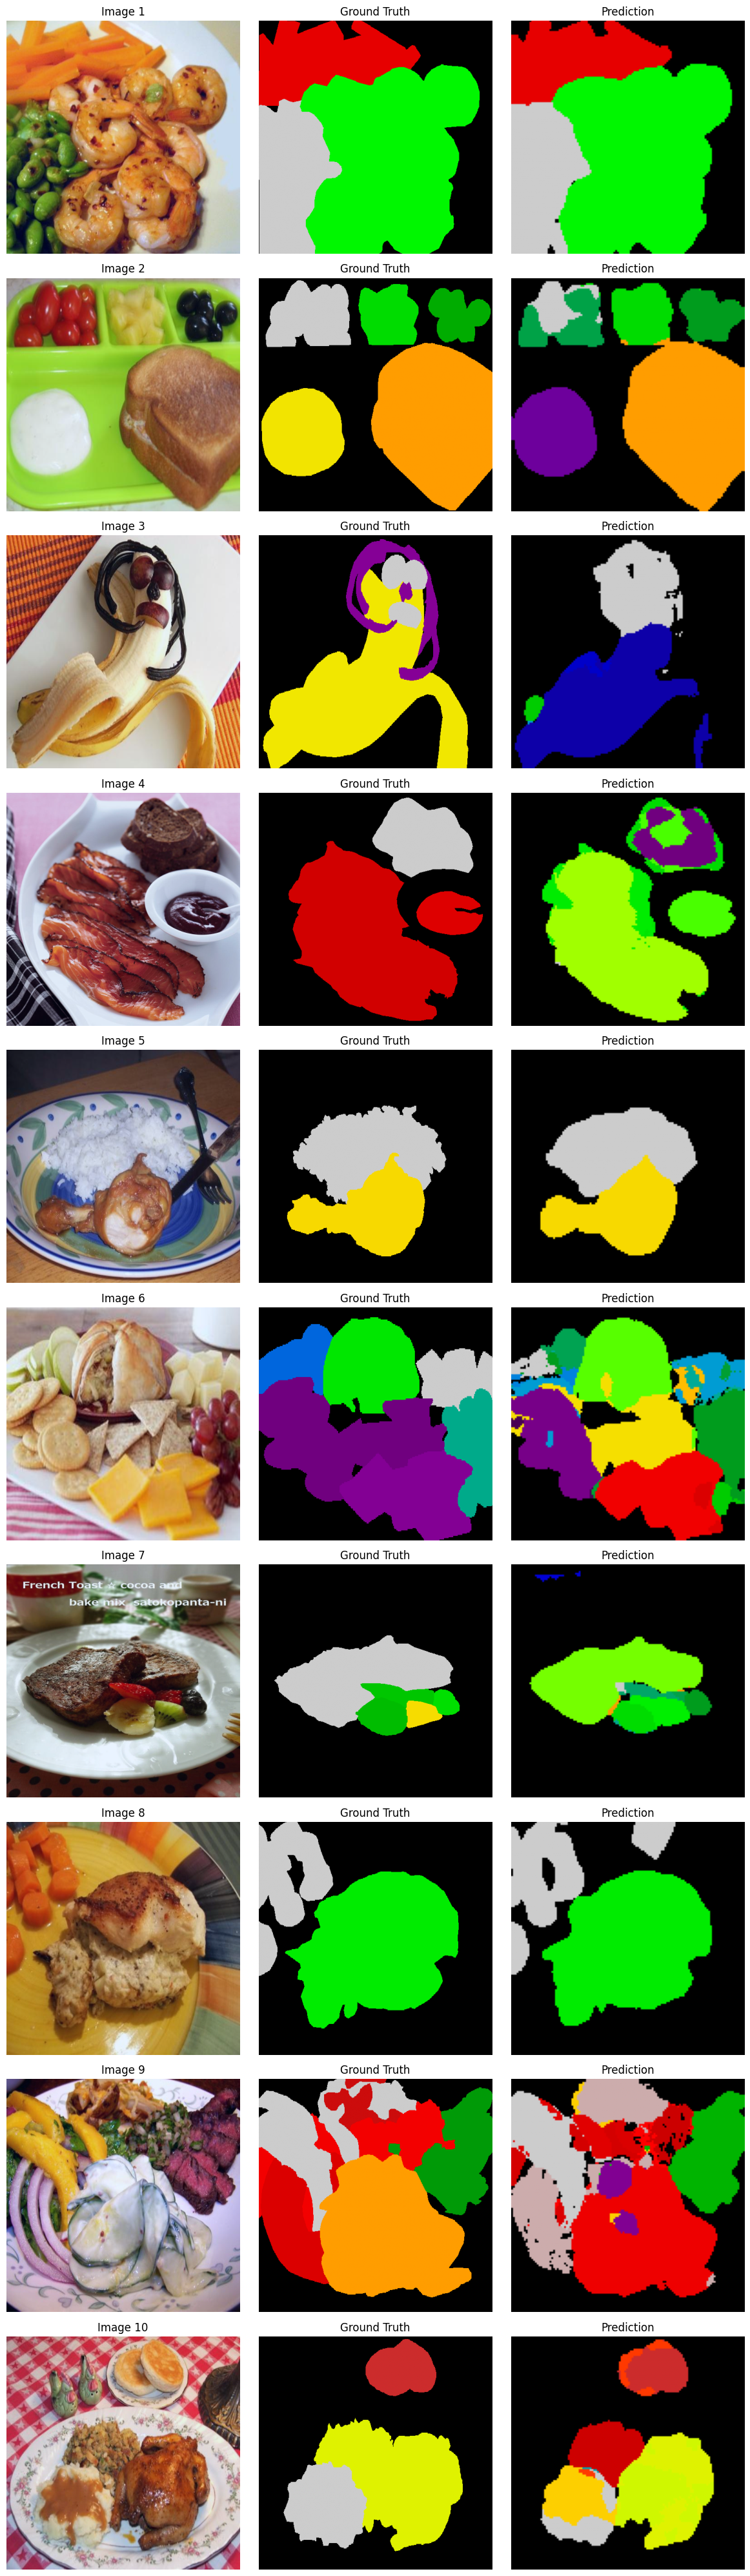

In [29]:
def visualize_predictions_indices(model, loader, device, indices):
    model.eval()

    # DataLoader는 배치 단위이므로, dataset 직접 접근하는 게 편함
    dataset = loader.dataset
    fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4 * len(indices)))

    if len(indices) == 1:
        axes = [axes]  # 단일 행이면 리스트로 변환

    with torch.no_grad():
        for row, i in enumerate(indices):
            img, mask = dataset[i]
            img, mask = img.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)

            out = model(img)
            logits = out.logits if hasattr(out, "logits") else out
            pred = torch.argmax(logits, dim=1)[0]

            # numpy 변환
            img_np = img[0].cpu().permute(1, 2, 0).numpy()
            mask_true = mask[0].cpu().numpy()
            mask_pred = pred.cpu().numpy()

            axes[row][0].imshow((img_np - img_np.min()) / (img_np.max() - img_np.min()))
            axes[row][0].set_title(f"Image {i}")
            axes[row][1].imshow(mask_true, cmap="nipy_spectral")
            axes[row][1].set_title("Ground Truth")
            axes[row][2].imshow(mask_pred, cmap="nipy_spectral")
            axes[row][2].set_title("Prediction")

            for ax in axes[row]:
                ax.axis("off")

    plt.tight_layout()
    plt.show()


# 실행: test dataset에서 1~10번 샘플
visualize_predictions_indices(model, test_loader, device, indices=list(range(1, 11)))